# Train level 0: Bayesian model
Based on:
https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks/comments

V0: Uses 10-fold CV 
V1: Uses predefined dataset

In [63]:
import random
import os
import datetime
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression

%matplotlib inline


In [60]:
dir_in = 'data_ori'
dir_feat = 'data'
dir_out = 'model_0_bayes'

description = 'models_bayes_0_V1'

## Load data

In [4]:
gatrain = pd.read_csv(os.path.join(dir_in, 'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(dir_in, 'gender_age_test.csv'))


In [5]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [6]:
phone = pd.read_csv('./data_ori/phone_brand_device_model.csv',encoding='utf-8')
phone = phone.drop_duplicates('device_id', keep='first')
phone.head(3)

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [7]:
lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

Xtrain = gatrain.merge(phone[['device_id','brand','model']], how='left',on='device_id')
Xtest = gatest.merge(phone[['device_id','brand','model']], how='left',on='device_id')
Xtrain.head(3)

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32-38,51,843
1,-2897161552818060146,M,35,M32-38,51,843
2,-8260683887967679142,M,35,M32-38,51,843


In [8]:
# Load CV sets
train_cv = pd.read_csv(os.path.join(dir_in, 'gender_age_train_cv.csv'))
test_cv = pd.read_csv(os.path.join(dir_in, 'gender_age_test_cv.csv'))

In [45]:
X_train, X_val = Xtrain.loc[train_cv.sample_nr, :], Xtrain.loc[test_cv.sample_nr, :]
y_train, y_val = y[train_cv.sample_nr], y[test_cv.sample_nr]

In [46]:
X_train.sample(10)

,device_id,gender,age,group,brand,model
1492,-6939393211204340051,F,22,F23-,13,264
42613,4707300503949486411,M,30,M29-31,51,865
21842,-1456321005371064978,M,45,M39+,13,214
12212,-9158734172103205235,F,22,F23-,7,160
27235,3570714957564079372,M,43,M39+,31,730
31731,1585261055807865350,F,37,F33-42,51,859
22800,1886824808792789562,F,41,F33-42,18,493
55268,-9215766592714662253,F,34,F33-42,117,1537
30518,-1516830556977021558,F,24,F24-26,31,730
67501,8724946949735794672,M,23,M23-26,31,665


## Calculate and store model

In [52]:
class GenderAgeGroupProbCombined(object):
    def __init__(self, prior_weight=(30,20), w=(1,1.3), by=('brand', 'model')):
        self.prior_weight_brand = prior_weight[0]
        self.prior_weight_model = prior_weight[1]
        
        self.w_brand = w[0]
        self.w_model = w[1]
        
        self.by_brand = by[0]
        self.by_model = by[1]
    
    def fit(self, df):
        
        self.prior_brand = df['group'].value_counts().sort_index()/df.shape[0]
        self.prior_model = df['group'].value_counts().sort_index()/df.shape[0]
        
        c_brand = df.groupby([self.by_brand, 'group']).size().unstack().fillna(0)
        c_model = df.groupby([self.by_model, 'group']).size().unstack().fillna(0)
        
        self.prob_brand = (c_brand.add(self.prior_weight_brand*self.prior_brand)).div(c_brand.sum(axis=1)+self.prior_weight_brand, axis=0)
        self.prob_model = (c_model.add(self.prior_weight_model*self.prior_model)).div(c_model.sum(axis=1)+self.prior_weight_model, axis=0)
        
        return self
    
    def predict_proba(self, df):
        pred_brand = df[[self.by_brand]].merge(self.prob_brand, 
                                   how='left', 
                                   left_on=self.by_brand, 
                                   right_index=True).fillna(self.prior_brand)[self.prob_brand.columns]
        pred_model = df[[self.by_model]].merge(self.prob_model, 
                                   how='left', 
                                   left_on=self.by_model, 
                                   right_index=True).fillna(self.prior_model)[self.prob_model.columns]
        
        pred_brand.loc[pred_brand.iloc[:,0].isnull(),:] = self.prior_brand
        pred_model.loc[pred_model.iloc[:,0].isnull(),:] = self.prior_model
        return ((pred_brand*self.w_brand + pred_model*self.w_model) / (self.w_brand + self.w_model)).values

In [53]:
n_models = 10
rs = 50

params = {'prior_weight': (30,20),
          'weight': (1, 1.3),
           'seed': rs}

In [57]:
clf = GenderAgeGroupProbCombined(params['prior_weight'], params['weight']).fit(X_train)
pred = clf.predict_proba(X_val)
cv_score= log_loss(y_val, pred)

models_out = [{'model': clf,
             'score': cv_score,
             'params': params}]
print cv_score

2.38916631078


In [64]:
outputfile = '{}_{}_{:.4f}_{:.4f}.pickle'.format(description, 
                                                 datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"),
                                                 cv_score,
                                                 -1)

output = {'script': 'train_model_0_bayesian',
          'features': None,
          'feature_sets': 'phone_brand_device_model.csv',
          'model_params': params,
          'no_models': n_models,
          'cross_validation': {'type': 'gender_age_train_cv.csv'},
          'models': models_out}


with open(os.path.join(dir_out, outputfile), 'wb') as f:
    pickle.dump(output,f)

## Bayesian model

In [11]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

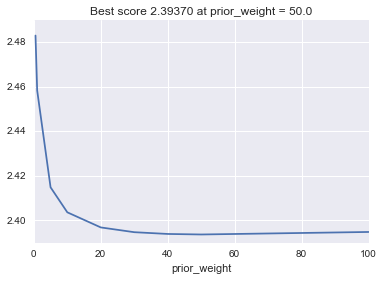

In [12]:
weights = [0.5, 1., 5., 10., 20.,30.,40.,50.,100.]
res = [score(Xtrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

In [13]:
# Best weight for brand: 40
# Best weight for device: 50

In [14]:
s = 100
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((Xtrain.shape[0],n_classes))
predm = np.zeros((Xtrain.shape[0],n_classes))
for itrain, itest in kf:
    train = Xtrain.iloc[itrain,:]
    test = Xtrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)


In [15]:
w1, w2 = 1, 1.3
log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.3893103376967981

We have the following variables for this model
- Prior weight
- Weights brand/model
- Seed
- Number of folds

### Test prior weight

In [16]:
s=9999
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((Xtrain.shape[0],n_classes))
predm = np.zeros((Xtrain.shape[0],n_classes))
for ws in [10., 20., 30., 40., 50., 60.]:
    for itrain, itest in kf:
        train = Xtrain.iloc[itrain,:]
        test = Xtrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=ws).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)
    print log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.3893546854
2.38927766956
2.3892597998
2.38926151891
2.38927146844
2.389285235


For brand: (consistent with seed)
10: 2.3895645807
20: 2.38951944857
30: 2.3895114353 * Minimum
40: 2.38951560074
50: 2.38952474388
60: 2.38953608403

For device: (consistent with seed)
10: 2.39029824291
20: 2.3895114353 * Minimum
30: 2.38965792994
40: 2.39001784009
50: 2.39043342904
60: 2.39085576399

### Weights brand/model

In [17]:
s=50
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((Xtrain.shape[0],n_classes))
predm = np.zeros((Xtrain.shape[0],n_classes))

for itrain, itest in kf:
    train = Xtrain.iloc[itrain,:]
    test = Xtrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)
print log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.3892800324


In [18]:
w1, w2 = 1, 1.3
for w2 in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]:
    print w2, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

1.1 : 2.38934992139
1.2 : 2.38929668366
1.3 : 2.3892800324
1.4 : 2.38929169768
1.5 : 2.38932529917
1.6 : 2.38937587558
1.7 : 2.38943954265
1.8 : 2.38951324136


1.1 : 2.38935143238
1.2 : 2.38930020121
1.3 : 2.389285235 * Minimum (consistent with different seeds)
1.4 : 2.38929832534
1.5 : 2.38933313955
1.6 : 2.38938475374
1.7 : 2.38944931332
1.8 : 2.38952378303

### Random seed

In [19]:
predbs = []
predms = []
for s in random.sample(xrange(99999), 50):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
    predb = np.zeros((ptrain.shape[0],n_classes))
    predm = np.zeros((ptrain.shape[0],n_classes))

    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)
    predbs.append(predb)
    predms.append(predm)
    print s, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

NameError: name 'ptrain' is not defined

In [ ]:
n = len(predbs)
log_loss(y, w1*sum(predbs)/n+w2*sum(predms)/n)

In [ ]:
for n in [1,2,5,10,20,30,40,50]:
    print n, ':', log_loss(y, w1*sum(predbs[0:n])/n+w2*sum(predms[0:n])/n)

Optimimum around 40 different seeds

### Number of folds

In [63]:
for n_fold in [5, 10, 20, 50, 100, 200, 500]:
    kf = StratifiedKFold(y, n_folds=n_fold, shuffle=True, random_state=s)
    predb = np.zeros((ptrain.shape[0],n_classes))
    predm = np.zeros((ptrain.shape[0],n_classes))

    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)

    print n_fold, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

5 : 2.39093825532
10 : 2.38959281588
20 : 2.38898929513
50 : 2.38890334591
100 : 2.38865502875
200 : 2.38864451041
500 : 2.38856407469


## Development

In [27]:
class GenderAgeGroupProbCombined(object):
    def __init__(self, prior_weight=(30,20), w=(1,1.3), by=('brand', 'model')):
        self.prior_weight_brand = prior_weight[0]
        self.prior_weight_model = prior_weight[1]
        
        self.w_brand = w[0]
        self.w_model = w[1]
        
        self.by_brand = by[0]
        self.by_model = by[1]
    
    def fit(self, df):
        
        self.prior_brand = df['group'].value_counts().sort_index()/df.shape[0]
        self.prior_model = df['group'].value_counts().sort_index()/df.shape[0]
        
        c_brand = df.groupby([self.by_brand, 'group']).size().unstack().fillna(0)
        c_model = df.groupby([self.by_model, 'group']).size().unstack().fillna(0)
        
        self.prob_brand = (c_brand.add(self.prior_weight_brand*self.prior_brand)).div(c_brand.sum(axis=1)+self.prior_weight_brand, axis=0)
        self.prob_model = (c_model.add(self.prior_weight_model*self.prior_model)).div(c_model.sum(axis=1)+self.prior_weight_model, axis=0)
        
        return self
    
    def predict_proba(self, df):
        pred_brand = df[[self.by_brand]].merge(self.prob_brand, 
                                   how='left', 
                                   left_on=self.by_brand, 
                                   right_index=True).fillna(self.prior_brand)[self.prob_brand.columns]
        pred_model = df[[self.by_model]].merge(self.prob_model, 
                                   how='left', 
                                   left_on=self.by_model, 
                                   right_index=True).fillna(self.prior_model)[self.prob_model.columns]
        
        pred_brand.loc[pred_brand.iloc[:,0].isnull(),:] = self.prior_brand
        pred_model.loc[pred_model.iloc[:,0].isnull(),:] = self.prior_model
        return (pred_brand*self.w_brand + pred_model*self.w_model) / (self.w_brand + self.w_model)

In [28]:
s = 50
kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=s)
pred = np.zeros((Xtrain.shape[0],n_classes))
predm = np.zeros((Xtrain.shape[0],n_classes))
for itrain, itest in kf:
    train = Xtrain.iloc[itrain,:]
    test = Xtrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProbCombined().fit(train)
    pred[itest,:] = clf.predict_proba(test)


In [26]:
print log_loss(y, pred)

2.3892800324
